# #winerec - A Wine Recommendation System

This notebook presents the code necessary to build the wine recommendation system. Its purpose is to show the process and demonstrate the sytem.

## Organiztion

The organization of the notebook follows the different steps undertaken to create the recommendation system:

1. Exploration of Data
2. Data Processing
3. Data Understanding
4. Testing Different Recommendation Systems
5. Conclusion

In [1]:
# IMPORTING THE NECESSARY PACKAGES AND FUNCTIONS:

# generic:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import time 

# more specific:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer # Normalize samples individually to unit norm.
import sklearn 
import pickle # to save models, for instance LDA outputs

# NLP:
import spacy # version 2.2.1 
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import word2vec
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD # LSA
from sklearn.decomposition import NMF # NMF
from sklearn.decomposition import LatentDirichletAllocation # LDA
import pyLDAvis # used to visualize and plot ouptut of LDA
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

## Data Exploration

The [dataset](https://www.kaggle.com/zynicide/wine-reviews) was uploaded on Kaggle by Zack Thout. It consists of 140’000 wine reviews scraped from the [WineEnthusiast](https://www.winemag.com/?s=&drink_type=wine) magazine website. I use a new version of the dataset, extracted on March 2019 (c.f. [discussion](https://www.kaggle.com/zynicide/wine-reviews/discussion/83970)) and found [here](https://www.kaggle.com/zynicide/wine-reviews/discussion/83970).  

We first explore the data. The observations will guide the next data processing steps.

In [2]:
# load data: 
raw_winedata = pd.read_csv("../data/winemag-data-190314.csv").drop("Unnamed: 0", axis=1) # indexes were stored as col
initial_number_of_rows = raw_winedata.shape[0]
print(raw_winedata.shape)
raw_winedata.head()

(141617, 14)


,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,vintage
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,2013.0
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,2011.0
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,2013.0
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013.0
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012.0


In [3]:
# variables types:
raw_winedata.dtypes

country                   object
description               object
designation               object
points                     int64
price                    float64
province                  object
region_1                  object
region_2                  object
taster_name               object
taster_twitter_handle     object
title                     object
variety                   object
winery                    object
vintage                  float64
dtype: object

In [4]:
# checking for missing values:
raw_winedata.isnull().sum()

country                     61
description                  0
designation              40182
points                       0
price                     9658
province                    61
region_1                 22886
region_2                 86832
taster_name              24917
taster_twitter_handle    30649
title                        0
variety                      1
winery                       0
vintage                   5234
dtype: int64

### Variables in the Dataset

|variable|short explanation|
|--------|-----------------|
|country|The country that the wine is from|
|description|Wine description by a _sommelier_, identified in the column "taster"|
|designation|The vineyard within the winery where the grapes that made the wine are from|
|points|The number of points WineEnthusiast rated the wine on a scale of 1-100 (they only post reviews for wines that score >=80)|
|price|The cost for a bottle of the wine in USD |
|province|The province or state that the wine is from|
|region_1|The wine growing area in a province or state (e.g. Napa)|
|region_2|Sometimes there are more specific regions specified within a wine growing area (e.g. Rutherford inside the Napa Valley)|
|taster_name|Name of the _sommelier_ who wrote the description|
|taster_twitter_handle| |
|title|The title of the wine review|
|variety|The type of grapes used to make the wine (e.g. Pinot Noir)|
|winery|The winery that made the wine|
|vintage|Extracted from "title" when present|

We first have a look at the most important variables.

#### Description

The variable that interest us the most is the variable _description_, as we will base our content-based recommendation system on it. There are no missing values, however some descriptions are duplicated:

In [5]:
# inspect duplicated description:
duplicates_description  = raw_winedata[raw_winedata.duplicated(subset='description', keep=False)].sort_values(by='description')
print('number of duplicated descriptions: ', duplicates_description.shape[0]/2)
# duplicates_description # if want to print duplicates

# note: there are no full duplicates of row:
# duplicates = raw_winedata[raw_winedata.duplicated()] # is empty

number of duplicated descriptions:  38.0


No rows are full duplicates. However, 38 descriptions occur twice. Usually the descriptions occuring twice are two different wines coming from the same region. Sometimes even from the same winery, but with a different designation (e.g. "reserve"). We cannot know if these duplicate descriptions are valid tasting description or copy-paste errors from the tasters. Thus, we could keep them and assume that the taster did voluntarily copy their description because the wine was indeed very similar. However we have to keep in mind that if two descriptions are exact copies, the similarity distance that we will compute, or tf-idf scores or topics, or actually any measure will be the same.  

To stay on the safe side, we will remove these duplicates when processing data.

In [6]:
# Some examples of descriptions:
for i in range(1,5):
    print(raw_winedata.description[i], '\n')

This is ripe and fruity, a wine that is smooth while still structured. Firm tannins are filled out with juicy red berry fruits and freshened with acidity. It's  already drinkable, although it will certainly be better from 2016. 

Tart and snappy, the flavors of lime flesh and rind dominate. Some green pineapple pokes through, with crisp acidity underscoring the flavors. The wine was all stainless-steel fermented. 

Pineapple rind, lemon pith and orange blossom start off the aromas. The palate is a bit more opulent, with notes of honey-drizzled guava and mango giving way to a slightly astringent, semidry finish. 

Much like the regular bottling from 2012, this comes across as rather rough and tannic, with rustic, earthy, herbal characteristics. Nonetheless, if you think of it as a pleasantly unfussy country wine, it's a good companion to a hearty winter stew. 



Already with this very small subset, we note that not all words or sentences used are directly related to taste. For instance: "although it will certainly be better from 2016" or "Much like the regular bottling from 2012". 

Number of characters in the longest descritption:  829 ; and in the shortest:  20 . The mean is  242.97805348227968  and the median 237.0


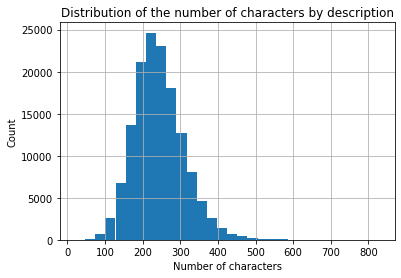

In [7]:
# length of the descriptions:
descr_lengths = raw_winedata.description.apply(len)
print("Number of characters in the longest descritption: ", max(descr_lengths), 
      '; and in the shortest: ', min(descr_lengths), '. The mean is ',
     np.mean(descr_lengths), ' and the median', np.median(descr_lengths))
# distribution: 
raw_winedata.description.apply(len).hist(bins=30)
plt.xlabel('Number of characters')
plt.ylabel('Count')
plt.title('Distribution of the number of characters by description')
plt.show()

We will remove descriptions with less than 100 characters because we consider that they do not carry enough information to be useful for NLP.

In [8]:
# # Use this code to print the short descriptions
# short_descr = raw_winedata[raw_winedata.description.apply(len) < 45].description
# for descr in short_descr:
#     print(descr)

After visual inspection, we found that short descriptions usually still carry relevant information, thus we will only get rid of the descriptions that are under 45 characters long.  

We can quickly have a look at the most frequent words used:

In [9]:
# Tokenization
# Note: we do not care here much about the details of the parameters,
# we just want to have a look at the most common words: 
vectorizer = CountVectorizer(analyzer='word',       
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             max_features=1000,             # max number of unique words
                            )

def get_top_n_words(corpus, n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    """
    vec = vectorizer.fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

print(get_top_n_words(raw_winedata['description'], 100))

[('wine', 88822), ('flavors', 68104), ('fruit', 54225), ('palate', 45084), ('aromas', 45055), ('acidity', 39090), ('finish', 38132), ('tannins', 35255), ('drink', 34930), ('black', 32737), ('cherry', 32237), ('ripe', 30574), ('red', 24253), ('spice', 21223), ('notes', 20654), ('nose', 20166), ('oak', 19383), ('rich', 19284), ('fresh', 18996), ('berry', 18963), ('dry', 18143), ('plum', 16635), ('apple', 15162), ('fruits', 14888), ('white', 14585), ('soft', 14472), ('offers', 14298), ('light', 14253), ('blend', 14128), ('texture', 14034), ('blackberry', 13768), ('sweet', 13713), ('crisp', 13666), ('dark', 13604), ('bodied', 13356), ('citrus', 12873), ('bright', 12222), ('shows', 12119), ('vanilla', 11766), ('juicy', 11249), ('cabernet', 11245), ('lemon', 11240), ('pepper', 11233), ('green', 10533), ('fruity', 10422), ('raspberry', 10369), ('firm', 10253), ('good', 10065), ('balanced', 9594), ('peach', 9398), ('touch', 9321), ('dried', 9263), ('chocolate', 8987), ('pear', 8871), ('charact

This looks quite promising, are most of those words are taste descriptors. 

#### Country

In [15]:
def my_barplot(dataframe, variable, title=None, xlabel=None, ylabel=None, fig_height=6):
    
    plt.figure(figsize=(6,fig_height))
    
    df_toplot = pd.DataFrame(dataframe[variable].value_counts().reset_index(level=0))
    df_toplot.columns = ['variable', 'count']
    
    sns.barplot(x='count', y='variable', data=df_toplot, color="steelblue")
    plt.title(title)
    plt.ylabel(variable)
    plt.show()

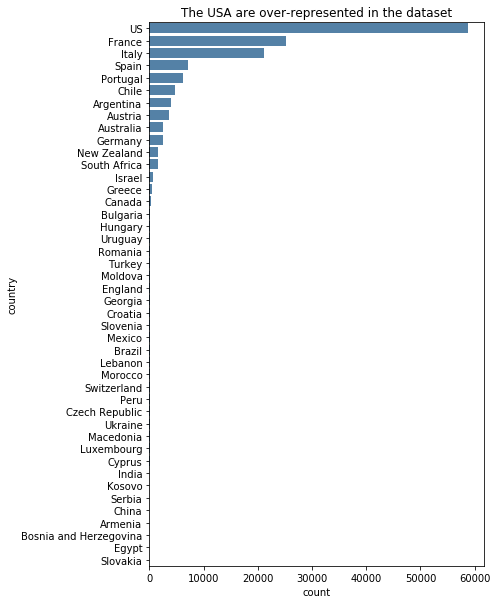

In [16]:
my_barplot(raw_winedata, 'country', title='The USA are over-represented in the dataset', 
           ylabel='', fig_height=10)
